# Good and Bad scenes analysis : can we caracterise when the comparison is good/bad ?

- compare with field intensity
- compare with trajectory straight or with oscillations

Input data:
- 3.5km filtered field and 48h filter on drifters velocity

#### Imports

In [61]:
import sys
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from utils_plots import plot_scene
import Drifters_processing


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

### Load scenes and field

In [62]:
# 3.5km filter + drifter filter velocity
dir_scenes_liss5 = '/home/bouxdecl/Documents/MEOM_driftersCompa/data/results/Scene_3point5kmfilterfield_48hfilterdrifter'
ds_swot_3point5 = xr.open_dataset('/home/bouxdecl/Documents/MEOM_driftersCompa/data/fields/field_L3SWOT_3point5km_Noneh.nc')


####
dir_scenes = dir_scenes_liss5
field = ds_swot_3point5
####

## Select GOOD / BAD Scenes

In [63]:
scenes = xr.open_mfdataset([os.path.join(dir_scenes, f) for f in os.listdir(dir_scenes)], combine='nested', concat_dim='scene')
scenes = scenes.rename_vars({'u_geo':'u_geo_swot', 'v_geo':'v_geo_swot', 'u_var':'u_var_swot', 'v_var':'v_var_swot'})
scenes = Drifters_processing.all_add_metrics(scenes)
S = scenes.where(scenes.n_points_compa > 96, drop=True) #remove scenes with less than 2 days of field comparison

### intensity comparison

intensity from trajectory

In [107]:
a =np.polyfit(X_fit, Y_fit, 1, full=True)
a

(array([-1.50201858,  0.84175625]),
 array([1305.42288961]),
 2,
 array([1.375207 , 0.3298571]),
 3.6919356460884956e-12)

Pearson correlation coefficient: -0.3063312585456628
P-value: 0.0
a (array([-1.50201858,  0.84175625]), array([1305.42288961]), 2, array([1.375207 , 0.3298571]), 3.6919356460884956e-12)


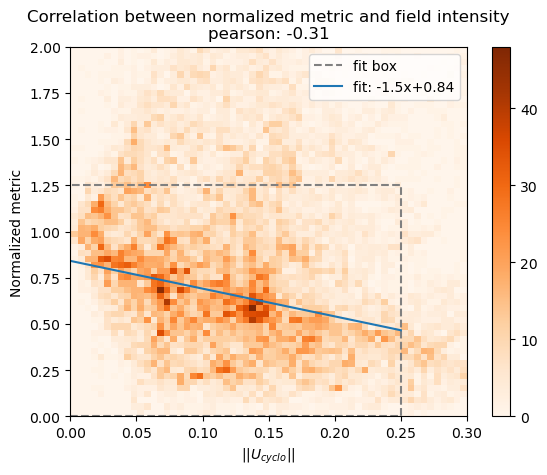

In [122]:
U = S.u_var_swot.values.flatten() + 1j* S.v_var_swot.values.flatten() 
#U = S.u_geo_swot.values.flatten() + 1j* S.v_geo_swot.values.flatten() 

X = np.abs(U)
Y = S.metric_norma_geo.values.flatten()

Xmax, Ymax = 0.25, 1.25
nan_index = np.logical_or(np.logical_or(np.isnan(X), (Y>Ymax)), (X>Xmax))
X_fit = X[~nan_index]
Y_fit = Y[~nan_index]

plt.plot([0,Xmax, Xmax, 0], [0, 0, Ymax, Ymax], ls='--', c='grey', label='fit box')

Xmax, Ymax = 0.3, 2
nan_index = np.logical_or(np.logical_or(np.isnan(X), (Y>Ymax)), (X>Xmax))
X_hist = X[~nan_index]
Y_hist = Y[~nan_index]

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(X_fit, Y_fit)

xarray = np.linspace(X_fit.min(), X_fit.max(), 100)
plt.plot(xarray, slope*xarray+intercept, label= 'fit: {:.2}x+{:.2}'.format(slope, intercept))

# Compute the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = scipy.stats.pearsonr(X_fit, Y_fit)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

_=plt.hist2d(X_hist, Y_hist, bins=60, cmap='Oranges')
plt.colorbar()
plt.xlim(0, Xmax)
plt.ylim(0, Ymax)
plt.xlabel('$||U_{cyclo}||$')
plt.ylabel('Normalized metric')

plt.legend()
plt.title('Correlation between normalized metric and field intensity\npearson: {:.2}'.format(correlation_coefficient))
print('a', a)

Pearson correlation coefficient: -0.4241847047356555
P-value: 0.0


Text(0, 0.5, 'metric norma')

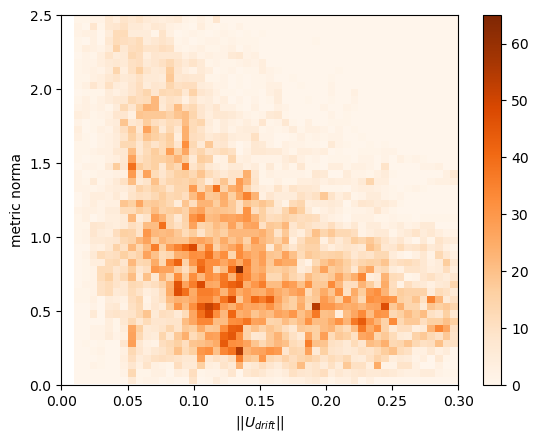

In [65]:
U = S.u_filtered.values.flatten() + 1j* S.v_filtered.values.flatten() 

X = np.abs(U)
Y = S.metric_norma_geo.values.flatten()

Xmax, Ymax = 0.25, 1.25
nan_index = np.logical_or(np.logical_or(np.isnan(X), (Y>Ymax)), (X>Xmax))
X_fit = X[~nan_index]
Y_fit = Y[~nan_index]

plt.plot([0,Xmax, Xmax, 0], [0, 0, Ymax, Ymax], ls='--', c='grey', label='fit box')

Xmax, Ymax = 0.3, 2
nan_index = np.logical_or(np.logical_or(np.isnan(X), (Y>Ymax)), (X>Xmax))
X_hist = X[~nan_index]
Y_hist = Y[~nan_index]

a, b = np.polyfit(X_fit, Y_fit, 1)
xarray = np.linspace(X_fit.min(), X_fit.max(), 100)
plt.plot(xarray, a*xarray+b, label= 'fit: {:.2}x+{:.2}'.format(a, b))

# Compute the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = scipy.stats.pearsonr(X_fit, Y_fit)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

_=plt.hist2d(X_hist, Y_hist, bins=50, cmap='Oranges')
plt.colorbar()
plt.xlim(0, Xmax)
plt.ylim(0, Ymax)
plt.xlabel('$||U_{cyclo}||$')
plt.ylabel('metric norma')

plt.legend()
plt.title('Correlation between normalized metric and field intensity\npearson: {:.2}'.format(correlation_coefficient))
print('a', a)

### Trajectory straithness

idea: strange trajectories have different parts uncorrelatted, so we can use the variance of the angle between two velocity vectors separated in time

Pearson correlation coefficient: 0.2769150507901458
P-value: 0.00012471571180821102


Text(0, 0.5, 'metric_norma')

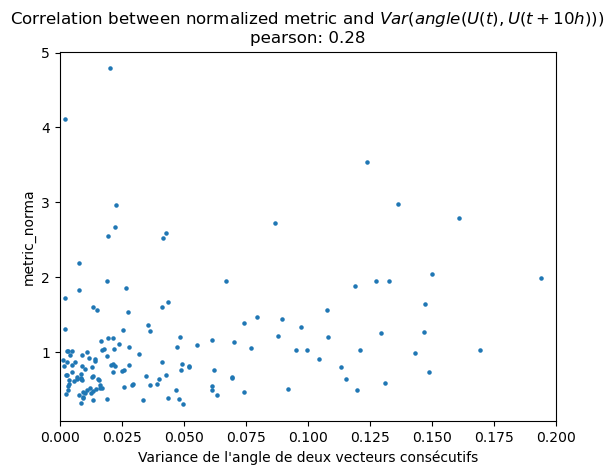

In [120]:
U = S.u_filtered.values + 1j* S.v_filtered.values
n_diff = 20
angle_next = np.angle(U[:, n_diff:] / U[:, :-n_diff])

X, Y = np.nanvar(angle_next, axis=1), S.metric_norma_var.mean(dim='s_obs').values

# Compute the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = scipy.stats.pearsonr(X, Y)
# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

plt.scatter(X, Y, s=5)
plt.xlim(-0.0002, 0.2)

plt.title('Correlation between normalized metric and $Var(angle(U(t), U(t+10h)))$ \npearson: {:.2}'.format(correlation_coefficient))
plt.xlabel("Variance de l'angle de deux vecteurs consécutifs")
plt.ylabel("Normalized metric")

In [ ]:
### freq compo